In [387]:
import pandas as pd
import calendar as cd
import numpy as np
import math 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
import os

DIRTY_FILE_NAME = 'ES=F.csv'
CLEAN_FILE_NAME = '(Clean)dowjones_stocks.csv'

## DATA EXTRACTION AND CLEANING AND FORMATTING
### Data Extraction
Putting the S&P 500 csv data into a dataframe

In [388]:
if os.path.exists(DIRTY_FILE_NAME):
    dowjones_stocks = pd.read_csv(DIRTY_FILE_NAME)
    print(dowjones_stocks.head())
else:
    print("Error: Input file not found")

         Date     Open     High      Low   Close  Adj Close    Volume
0  2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
1  2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2  2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
3  2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
4  2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


### Data Cleaning

The S&P 500 stock price dataset contains a number of null records typically during holidays or weekends, which are days when the stock market is closed. To clean this dataset, we will simply remove all null records. Due to the missing dates, it should be noted that the stock price forecasting model will not predict stock prices for each subsequent days. Rather, we should assume that the forecasting model will predict stock prices for the next subsequent day in which the stock price would typically be observed and recorded (i.e. non-weekends and non-holidays).

In [389]:
dowjones_stocks_cleaned = dowjones_stocks.loc[dowjones_stocks["Open"].isnull() == False]
dowjones_stocks_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,1485.25,1489.75,1462.25,1467.50,1467.50,104794.0
1,2000-09-19,1467.00,1482.75,1466.75,1478.50,1478.50,103371.0
2,2000-09-20,1478.75,1480.50,1450.25,1469.50,1469.50,109667.0
3,2000-09-21,1470.25,1474.00,1455.50,1469.50,1469.50,98528.0
4,2000-09-22,1454.75,1471.00,1436.75,1468.50,1468.50,97416.0
...,...,...,...,...,...,...,...
6189,2020-11-16,3587.00,3637.00,3586.50,3623.00,3623.00,1303941.0
6190,2020-11-17,3625.50,3630.00,3584.25,3606.75,3606.75,1268206.0
6191,2020-11-18,3604.50,3623.25,3556.50,3565.00,3565.00,1325309.0
6192,2020-11-19,3562.00,3582.75,3542.25,3580.00,3580.00,1291117.0


Check if there are any null values left in the dataset. There are none left.

In [390]:
dowjones_stocks_cleaned.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [391]:
#save cleaned data without the index column.
dowjones_stocks_cleaned.to_csv(CLEAN_FILE_NAME, index=0)

## BREAK POINT 1: Data Cleaned and saved till here. Can begin from here if saved file is available

In [392]:
if os.path.exists(CLEAN_FILE_NAME):
    dowjones_stocks_cleaned = pd.read_csv(CLEAN_FILE_NAME,index_col=['Date'])
    print(dowjones_stocks_cleaned.head())
else:
    print("Error: Clean File not found. Restart from the beginning")

               Open     High      Low   Close  Adj Close    Volume
Date                                                              
2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


# Splitting the Data

We have 10 years worth of data. Will use 9 years of data to predict the last year.
Will break the data down into weekly data and then use that to predict the daily closing price for each day a for a week. We will also remove the "Adjusted Close" column as it is the same as the "Close" column.

In [393]:
dowjones_stocks_cleaned_copy = dowjones_stocks_cleaned.copy()
del dowjones_stocks_cleaned_copy["Adj Close"]
dowjones_stocks_cleaned_copy

,Open,High,Low,Close,Volume
Date,,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50,104794.0
2000-09-19,1467.00,1482.75,1466.75,1478.50,103371.0
2000-09-20,1478.75,1480.50,1450.25,1469.50,109667.0
2000-09-21,1470.25,1474.00,1455.50,1469.50,98528.0
2000-09-22,1454.75,1471.00,1436.75,1468.50,97416.0
...,...,...,...,...,...
2020-11-16,3587.00,3637.00,3586.50,3623.00,1303941.0
2020-11-17,3625.50,3630.00,3584.25,3606.75,1268206.0
2020-11-18,3604.50,3623.25,3556.50,3565.00,1325309.0


In [394]:
def split(dataset):
    dataset = dataset.values
    length = len(dataset)
    print("Length=",length)
    total_weeks = int(length/5)
    print("Total Weeks=",total_weeks)
    
    #use last 1 year as test data set, everything else as train dataset
    WEEKS_IN_ONE_YEAR = 52
    ONE_YEAR_WORK_DAYS = 5*52
    
    train = dataset[0:-ONE_YEAR_WORK_DAYS]
    test = dataset[-ONE_YEAR_WORK_DAYS:]
    
    #convert to array
    train = np.array(train)
    test = np.array(test)
    
    print("-----TRAIN DATA-----")
    print("Length=",len(train))
    print("-----TEST DATA-----")
    print("Length=",len(test))
    print(train[0])
    print(test[0])
    return train,test
    
train_data,test_data = split(dowjones_stocks_cleaned_copy)

Length= 5131
Total Weeks= 1026
-----TRAIN DATA-----
Length= 4871
-----TEST DATA-----
Length= 260
[  1485.25   1489.75   1462.25   1467.5  104794.  ]
[   3237.      3261.75    3234.25    3259.   1416241.  ]


### What to predict?
Use 15 days of the available data with features Open Price, High, Low, Close, and Volume to predict the next 5 days of Close Price.

In [395]:
COLUMN_TO_PREDICT = 3 #Closing cost for the day
NUMBER_OF_DAYS_DATA_TO_USE = 15
NUMBER_OF_DAYS_DATA_TO_PREDICT = 5
NUMBER_OF_COLUMNS = train_data.shape[1]

#split the given data into inputs and outputs. We can use last 7 days data to predict the next day 
# or we can use monthly data to predict. It depends onm how we want to model the data
# and will experiment with various models
#if column_with_result is None, then trying to make data for validation
def convert_data_into_io(input_data, steps, column_with_result, num_of_days_to_predict):
    print(column_with_result)
    x,y = list(), list()
    
    for i in range(len(input_data)):
        end = i + steps
        if end+1 > len(input_data) or end+num_of_days_to_predict > len(input_data):
            break
        
        _x = input_data[i:end,]
        
        _y = input_data[end:end+num_of_days_to_predict,column_with_result]
        
        y.append(_y)
        x.append(_x)
        
    return np.array(x), np.array(y)

In [396]:
train_x,train_y = convert_data_into_io(train_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Train Data:", len(train_x))
print("Sample Train Input Data:")
print(train_x[1])
print("Sample Train Output Data:")
print(train_y[1])
print("------------------------")

test_x,test_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Test Data:", len(test_x))
print("Sample Test Input Data:")
print(test_x[0])
print("Sample Test Output Data:")
print(test_y[0])
print("-------------------------")

3
------------------------
Total Train Data: 4852
Sample Train Input Data:
[[  1467.     1482.75   1466.75   1478.5  103371.  ]
 [  1478.75   1480.5    1450.25   1469.5  109667.  ]
 [  1470.25   1474.     1455.5    1469.5   98528.  ]
 [  1454.75   1471.     1436.75   1468.5   97416.  ]
 [  1469.5    1477.75   1455.5    1461.    85491.  ]
 [  1461.     1467.     1442.5    1443.    99803.  ]
 [  1444.     1456.     1438.25   1446.75 101996.  ]
 [  1447.75   1481.     1445.     1476.    84280.  ]
 [  1473.     1473.25   1454.     1454.    78277.  ]
 [  1453.75   1464.25   1447.5    1456.25  84100.  ]
 [  1457.25   1474.     1438.75   1441.5   89440.  ]
 [  1442.     1457.25   1432.5    1450.25 101607.  ]
 [  1449.5    1462.     1447.25   1456.    92232.  ]
 [  1456.     1460.5    1411.5    1426.25  95257.  ]
 [  1425.25   1426.75   1408.     1416.5   67432.  ]]
Sample Train Output Data:
[1391.   1378.5  1344.   1386.25 1392.  ]
------------------------
3
------------------------
Total Tes

## Initial LSTM Model (2000 Epochs with ADAM)

In [397]:
# Number of epochs and optimizer
epochs = 2000
optimizer = "adam"

# Number of features
num_features = train_x.shape[2]

# name of model and history 
initial_model_name = "initial_model.h5"
initial_history_name = "initial_model_history_1.csv"

# The model
def stock_model(num_features, epochs, opt, model_name, history_name):
    stock_model = keras.Sequential()
    stock_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(NUMBER_OF_DAYS_DATA_TO_USE, num_features)))
    stock_model.add(LSTM(100, activation='relu'))
    stock_model.add(Dense(NUMBER_OF_DAYS_DATA_TO_PREDICT))

    print(stock_model.summary())
    
    stock_model.compile(optimizer=opt, loss='mae')
    stock_model_history = stock_model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y))
    
    stock_model.save(initial_model_name)

    pd.DataFrame(stock_model_history.history).to_csv(initial_history_name)
    
    return stock_model, stock_model_history

fit model if none exists

In [398]:
#SAVE MODEL AFTER FITTING. If saved model is available, then reload that
initial_model = None
initial_model_history = pd.DataFrame()

if os.path.exists(initial_model_name):
    print("Model Found: Loading...")
    initial_model = load_model(initial_model_name)
    initial_model_history = pd.read_csv(initial_history_name)
    print(model.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    initial_model, initial_model_history = stock_model(num_features, epochs, optimizer, initial_model_name, initial_history_name)
    initial_model_history = initial_model_history.history

Model Found: Loading...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Model Loaded!


Plot loss of model

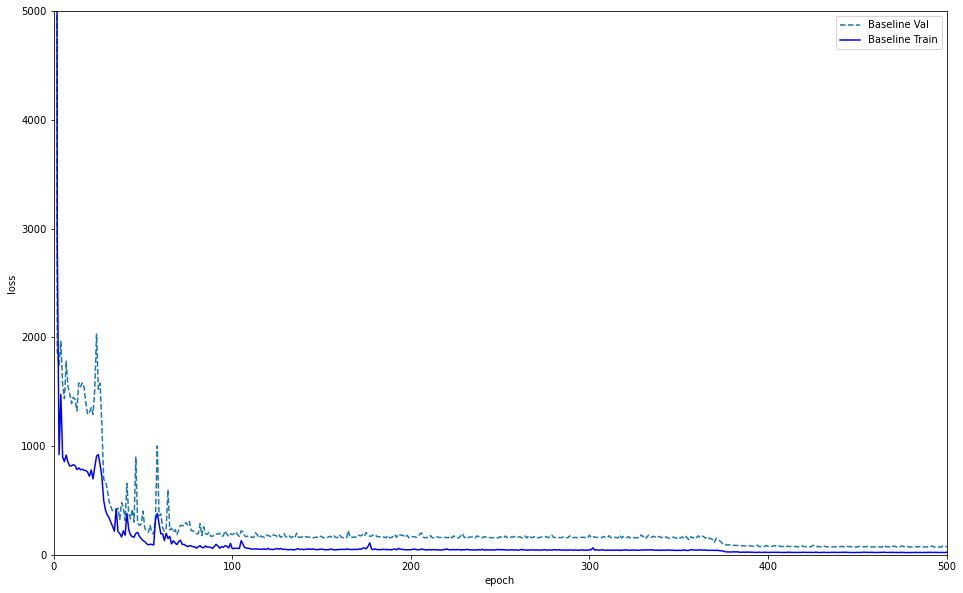

In [431]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), initial_model_history['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), initial_model_history['loss'], color='blue', label='Baseline Train')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.xlim([0,500])
plt.ylim([0,5000])
#plt.xlim([0,max(np.arange(0,epochs,1))])
#plt.ylim([0,max(max(initial_model_history['val_loss']),max(initial_model_history['loss']))])
plt.legend()
plt.show()

## LSTM Model (2000 Epochs with ADAM)
Creating a 5 day closing stock price forecasting model with LSTM with 2000 epochs using adam

In [400]:
# Number of epochs and optimizer
epochs = 2000
optimizer = "adam"

# Number of features
num_features = train_x.shape[2]

# name of model and history 
model_name_1 = "stock_model_1.h5"
history_name_1 = "stock_model_history_1.csv"

# The model
def stock_model(num_features, epochs, opt, model_name, history_name):
    stock_model = keras.Sequential()
    stock_model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(NUMBER_OF_DAYS_DATA_TO_USE, num_features)))
    stock_model.add(Dense(NUMBER_OF_DAYS_DATA_TO_PREDICT))

    print(stock_model.summary())
    
    stock_model.compile(optimizer=opt, loss='mae')
    stock_model_history = stock_model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y))
    
    stock_model.save(model_name)

    pd.DataFrame(stock_model_history.history).to_csv(history_name)
    
    return stock_model, stock_model_history

Loading the forecasting model with 2000 epochs if it exists. If not, run the forecasting model and fit a new model.

In [401]:
#SAVE MODEL AFTER FITTING. If saved model is available, then reload that
model = None
model_history = pd.DataFrame()

if os.path.exists(model_name_1):
    print("Model Found: Loading...")
    model = load_model(model_name_1)
    model_history = pd.read_csv(history_name_1)
    print(model.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model, model_history = stock_model(num_features, epochs, optimizer, model_name_1, history_name_1)
    model_history = model_history.history

Model Found: Loading...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Model Loaded!


Plotting the loss

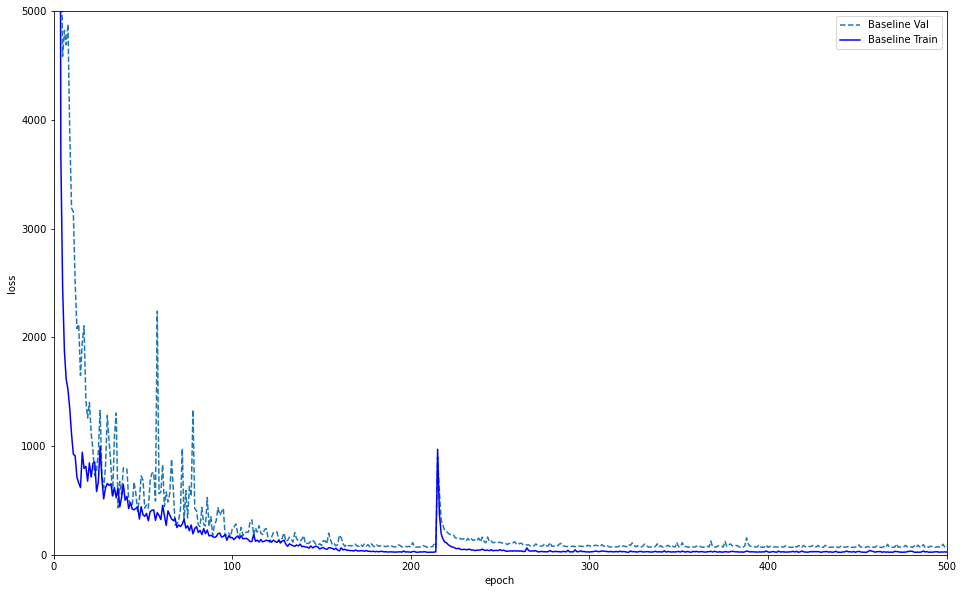

In [430]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history['loss'], color='blue', label='Baseline Train')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.xlim([0,500])
plt.ylim([0,5000])
#plt.xlim([0,max(np.arange(0,epochs,1))])
#plt.ylim([0,max(max(model_history['val_loss']),max(model_history['loss']))])
plt.legend()
plt.show()

In [403]:
#function for preditions and error calculating
def predict(model, input_data):
    input_data = input_data.reshape(1,NUMBER_OF_DAYS_DATA_TO_USE,NUMBER_OF_COLUMNS)
    value = model.predict(input_data, verbose=0)
    return value[0][0]

def check_all_test_data(data, model):
    predicted_data = []
    i = 1
    for d in data:
        print('.',end='')
        if i%20 == 0: print('-',i)
        d = d.reshape((1, NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS))
        # below predicts the first value of the 5 predicted values
        data = model.predict(d)
        predicted_data.append(list(data[0]))
        i = i+1
    print('-',i)
    return np.array(predicted_data)

Predict values for the validation data

In [404]:
test_x,actual_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
print("End of data prediction!")

3
Start predicting data...
....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


#### from matplotlib import pyplot as plt
Below data shows the first predicted day of each set of 5 days that were predicted from each set of 15 prior days

from sklearn.metrics import mean_squared_error
import math 

#plot actual and predicted
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y, label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()


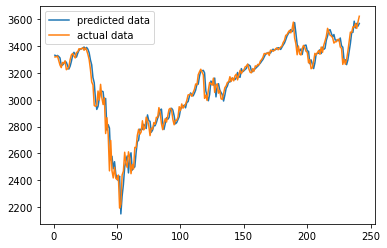

In [405]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y[:,0], label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

Calculates the MSE, RMSE, and visualizes the percentage differences for each set of predicted values when compared to the real closing prices.

RMSE =  97.99438128763225


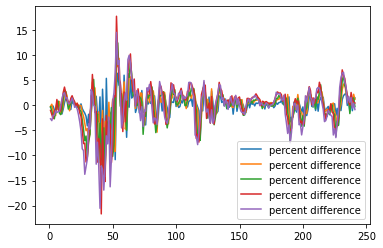

In [406]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## LSTM MODEL (2000 Epochs with RMSPROP)
Creating a 5 day closing stock price forecasting model with LSTM with 2000 epochs using rmsprop

In [407]:
optimizer_2 = "rmsprop"
model_name_2 = "stock_model_2.h5"
history_name_2 = "stock_model_history_2.csv"

Running the model that uses RMSprop if it exists

In [408]:
model_2 = None
model_history_2 = pd.DataFrame()

if os.path.exists(model_name_2):
    print("Model Found: Loading...")
    model_2 = load_model(model_name_2)
    model_history_2 = pd.read_csv(history_name_2)
    print(model_2.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model_2, model_history_2 = stock_model(num_features, epochs, optimizer_2, model_name_2, history_name_2)
    model_history_2 = model_history_2.history

Model Found: Loading...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               42400     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Model Loaded!


Plotting the loss

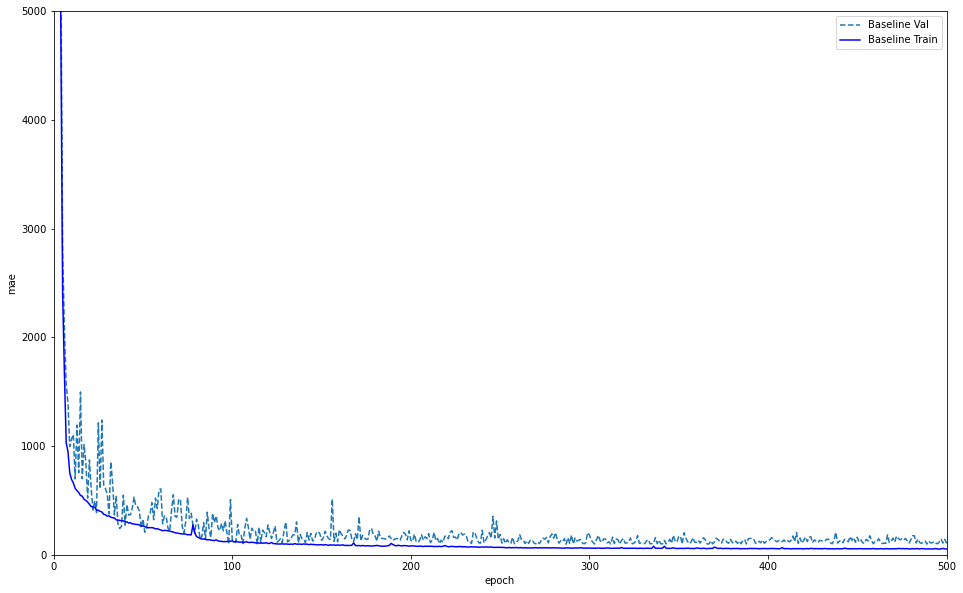

In [432]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history_2['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history_2['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,500])
plt.ylim([0,5000])
#plt.xlim([0,max(np.arange(0,epochs,1))])
#plt.ylim(50000)
plt.legend()
plt.show()

In [410]:
predicted_y_2 = check_all_test_data(test_x, model_2)
print("End of data prediction!")

....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


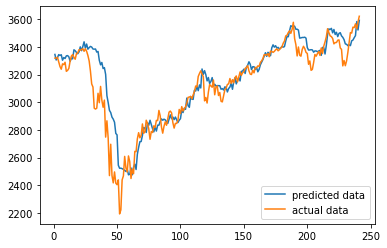

In [411]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y_2[:,0], label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

RMSE =  150.41829196854792


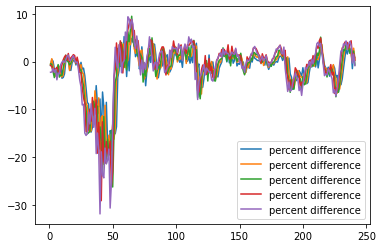

In [412]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y_2)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y_2[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## LSTM MODEL (2000 Epochs with NADAM)
Creating a 5 day closing stock price forecasting model with LSTM with 2000 epochs using nadam

In [413]:
optimizer_3 = "nadam"
model_name_3 = "stock_model_3.h5"
history_name_3 = "stock_model_history_3.csv"

In [414]:
model_3 = None
model_history_3 = pd.DataFrame()

if os.path.exists(model_name_3):
    print("Model Found: Loading...")
    model_3 = load_model(model_name_3)
    model_history_3 = pd.read_csv(history_name_3)
    print(model_3.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model_3, model_history_3 = stock_model(num_features, epochs, optimizer_3, model_name_3, history_name_3)
    model_history_3 = model_history_3.history

Model Found: Loading...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               42400     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Model Loaded!


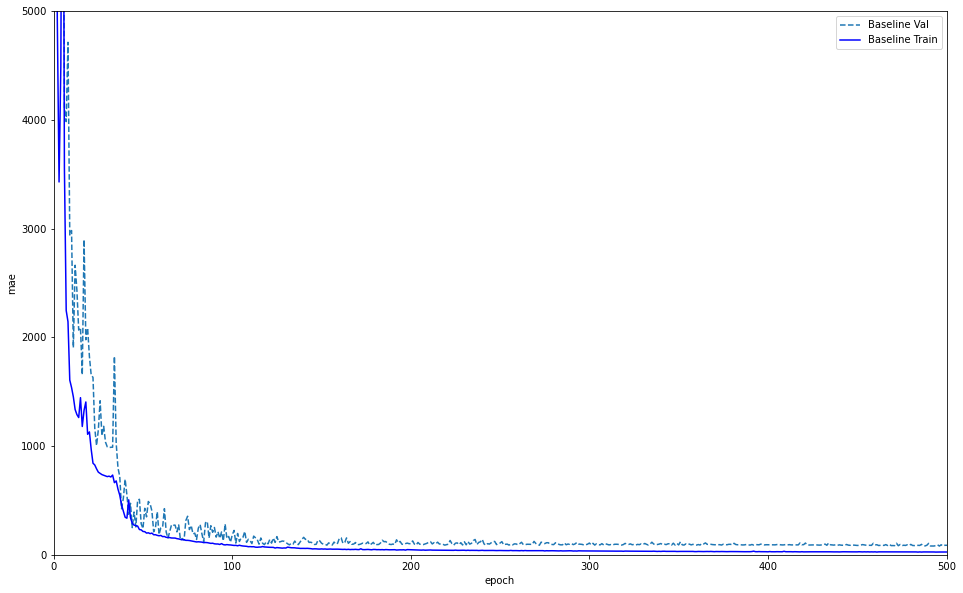

In [433]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history_3['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history_3['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,500])
plt.ylim([0,5000])
#plt.xlim([0,max(np.arange(0,epochs,1))])
#plt.ylim([0,max(max(model_history_3['val_loss']),max(model_history_3['loss']))])
plt.legend()
plt.show()

In [416]:
predicted_y_3 = check_all_test_data(test_x, model_3)
print("End of data prediction!")

....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


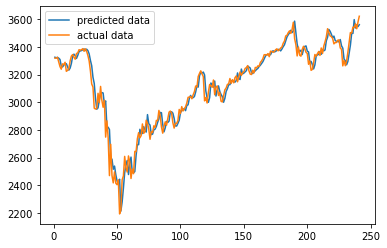

In [417]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y_3[:,0], label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

RMSE =  99.01501352984091


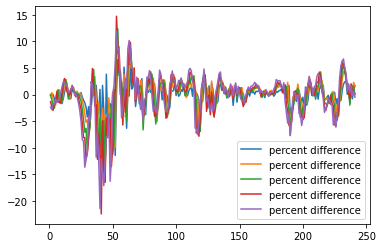

In [418]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y_3)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y_3[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## Naive Model (Moving Average)

In [419]:
test_values = test_data[:,3]
moving_averages_pred = []

for i in range(len(test_values)):
    end = i + NUMBER_OF_DAYS_DATA_TO_USE
    
    if end+1 > len(test_values) or end+NUMBER_OF_DAYS_DATA_TO_PREDICT > len(test_values):
            break
    
    moving_prediction_set = list(test_values[i:end])
    
    for x in range(NUMBER_OF_DAYS_DATA_TO_PREDICT):
        
        end_x = x + NUMBER_OF_DAYS_DATA_TO_USE
        
        pred_value = np.mean(moving_prediction_set[x:end_x])         
        
        moving_prediction_set.append(pred_value)
                          
    moving_averages_pred.append(moving_prediction_set[NUMBER_OF_DAYS_DATA_TO_USE:NUMBER_OF_DAYS_DATA_TO_USE+NUMBER_OF_DAYS_DATA_TO_PREDICT])
    
moving_averages_pred = np.array(moving_averages_pred)

moving_averages_pred

array([[3273.81666667, 3274.80444444, 3277.42474074, 3281.11972346,
        3283.62770502],
       [3277.85      , 3280.67333333, 3284.58488889, 3287.32388148,
        3290.79547358],
       [3283.46666667, 3287.56444444, 3290.50207407, 3294.18554568,
        3296.44791539],
       ...,
       [3417.56666667, 3415.45444444, 3413.03474074, 3414.33705679,
        3416.42619391],
       [3423.11666667, 3421.20777778, 3423.05496296, 3425.72529383,
        3436.54031342],
       [3431.8       , 3434.35333333, 3437.77688889, 3449.39534815,
        3459.20503802]])

In [420]:
naive_mse = mean_squared_error(actual_y, moving_averages_pred)
naive_rmse = math.sqrt(naive_mse)
print("RMSE for the naive moving average model = ",naive_rmse)

RMSE for the naive moving average model =  150.12993388495775


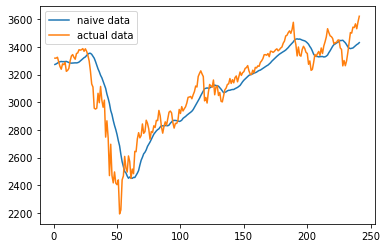

In [421]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, moving_averages_pred[:,0], label='naive data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

## Example Demo

past data prediction

In [422]:
start = 40
end = start + 15

pred_start = end
pred_data = end + 5

sample = np.array([test_data[start:end]])
sample_actual = test_data[pred_start:pred_data,3]

def predict_with_model(model, data):
    prediction = model.predict(sample)
    return prediction[0]

In [423]:
for each in sample:
    print("Closing stock prices for prior 15 days")
    print(each[:,0:4])

# Use model
# model_2
# model_3
print("\nStock closing price predictions for the next 5 days")
for each in predict_with_model(model, sample):
    print(each)

print("\nActual stock closing prices for the next 5 days")   
for each in sample_actual:
    print(each)

Closing stock prices for prior 15 days
[[3391.75 3397.5  3339.25 3369.25]
 [3367.   3369.25 3328.   3339.25]
 [3309.   3312.   3289.5  3299.25]
 [3309.   3312.   3213.75 3226.25]
 [3223.   3259.5  3117.25 3132.5 ]
 [3138.   3182.   3091.   3110.25]
 [3100.25 3117.   2944.5  2957.  ]
 [2950.   2996.   2853.25 2951.  ]
 [2950.   2996.   2853.25 2957.  ]
 [2900.   3093.25 2889.25 3065.  ]
 [3077.   3137.   2973.   2997.  ]
 [2988.25 3129.5  2976.5  3114.75]
 [3109.25 3113.75 2996.5  3015.5 ]
 [3024.25 3037.   2898.   2964.  ]
 [3024.25 3037.   2898.   3015.5 ]]

Stock closing price predictions for the next 5 days
3009.1575
3003.3877
3012.3145
3003.9312
3021.2412

Actual stock closing prices for the next 5 days
2747.75
2865.75
2740.25
2469.0
2696.0


Recent data prediction

In [424]:
# data from november 4, 2020 to november 24,2020
input_stocks = [[[3362.75,3480.00,3319.00,3435.00,2813083],    
[3448.00,3522.50,3428.25,3504.75,1671417],
[3508.75,3519.00,3456.75,3500.75,1671417],
[3522.50,3668.00,3515.75,3544.00,2605322],
[3549.50,3562.75,3506.50,3541.00,2160319],
[3546.25,3576.75,3531.00,3568.00,1324983], 
[3574.50,3574.50,3513.00,3532.50,1685890],
[3537.50,3590.00,3518.00,3582.00,1685890],
[3587.00,3637.00,3586.50,3623.00,1303941],
[3625.50,3630.00,3584.25,3606.75,1268206],
[3604.50,3623.25,3556.50,3565.00,1325309],
[3562.00,3582.75,3542.25,3580.00,1291117],
[3560.00,3582.50,3542.75,3554.25,1291117],
[3546.50,3588.00,3545.50,3576.00,1204848],
[3576.00,3640.00,3575.25,3632.75,1288993]]]


print("\nAll data in prior 15 days")   
for each in input_stocks[0]:
    print(each)

print("\nStock closing price predictions for the next 5 days")
for each in predict_with_model(model, input_stocks):
    print(each)
 
print("\nActual stock closing prices for the next 5 days")
for each in [3627.25, 3623.25, 3660.50, 3667.25, 3669.50]:
    print(each)


All data in prior 15 days
[3362.75, 3480.0, 3319.0, 3435.0, 2813083]
[3448.0, 3522.5, 3428.25, 3504.75, 1671417]
[3508.75, 3519.0, 3456.75, 3500.75, 1671417]
[3522.5, 3668.0, 3515.75, 3544.0, 2605322]
[3549.5, 3562.75, 3506.5, 3541.0, 2160319]
[3546.25, 3576.75, 3531.0, 3568.0, 1324983]
[3574.5, 3574.5, 3513.0, 3532.5, 1685890]
[3537.5, 3590.0, 3518.0, 3582.0, 1685890]
[3587.0, 3637.0, 3586.5, 3623.0, 1303941]
[3625.5, 3630.0, 3584.25, 3606.75, 1268206]
[3604.5, 3623.25, 3556.5, 3565.0, 1325309]
[3562.0, 3582.75, 3542.25, 3580.0, 1291117]
[3560.0, 3582.5, 3542.75, 3554.25, 1291117]
[3546.5, 3588.0, 3545.5, 3576.0, 1204848]
[3576.0, 3640.0, 3575.25, 3632.75, 1288993]

Stock closing price predictions for the next 5 days
3009.1575
3003.3877
3012.3145
3003.9312
3021.2412

Actual stock closing prices for the next 5 days
3627.25
3623.25
3660.5
3667.25
3669.5
